# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        #'number_of_variables': 43, 
        'num_classes': 2,
        #'categorical_indices': [],
        
        'function_generation_type': 'make_classification',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        #'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        #'number_of_lambda_weights': None,
        
        #'number_initializations_lambda': 1, 
        
        #'number_of_trained_lambda_nets': 100,
    },     
    
    'i_net': {
        'dense_layers': [1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.2, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy', #binary_crossentropy
        'metrics': ['mse', 'binary_accuracy'],
        
        'epochs': 150, 
        'early_stopping': False,
        'batch_size': 256,

        #'interpretation_dataset_size': 100,
                
        #'test_size': 2, #Float for fraction, Int for number 0
        
        'function_representation_type': 1, # 1=standard representation; 2=sparse representation with classification for variables
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
        'soft_labels': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {               
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [6]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

#config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
#config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
#config['function_family']['function_representation_length'] = ( 
#       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
#       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * number_of_classes if function_representation_type == 1 and dt_type == 'SDT'
#  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
#  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
#  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
#  else None
#                                                            )

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
#globals().update(generate_paths(config, path_type='interpretation_net'))

#create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
#print(path_identifier_interpretation_net)

#print(path_identifier_lambda_net_data)


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  0


## Interpretation Network Training

In [10]:
#%load_ext autoreload

In [11]:
def generate_inet(config, evaluation_data=None):

    callback_names = []

    ############################## DATA PREPARATION ###############################

    random_model = generate_base_model(config)
    #random_evaluation_dataset =  np.random.uniform(low=0, high=0.2, size=(config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables']))
    if evaluation_data is None:
        np.random.seed(RANDOM_SEED)
        random_evaluation_dataset =  np.random.uniform(low=config['data']['x_min'], high=config['data']['x_max'], size=(config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables']))
    else:
        random_evaluation_dataset = evaluation_data
        
    random_network_parameters = random_model.get_weights()
    network_parameters_structure = [network_parameter.shape for network_parameter in random_network_parameters]         

    #(X_train, X_train_flat, y_train) = generate_inet_train_data(lambda_net_dataset_train, config)
    #(X_valid, X_valid_flat, y_valid) = generate_inet_train_data(lambda_net_dataset_valid, config)
    #(X_test, X_test_flat, y_test) = generate_inet_train_data(lambda_net_dataset_test, config)


    ############################## OBJECTIVE SPECIFICATION AND LOSS FUNCTION ADJUSTMENTS ###############################             
    loss_function = inet_decision_function_fv_loss_wrapper(random_evaluation_dataset, random_model, network_parameters_structure, config)
    metrics = [
               inet_decision_function_fv_metric_wrapper(random_evaluation_dataset, random_model, network_parameters_structure, config, 'binary_crossentropy'), 
               #inet_decision_function_fv_metric_wrapper(random_evaluation_dataset, random_model, network_parameters_structure, config, 'mae'), 
               inet_decision_function_fv_metric_wrapper(random_evaluation_dataset, random_model, network_parameters_structure, config, 'binary_accuracy')
    ]

    ############################## BUILD MODEL ###############################

    inputs = Input(shape=number_of_lambda_weights, name='input')

    hidden = tf.keras.layers.Dense(config['i_net']['dense_layers'][0], name='hidden1_' + str(config['i_net']['dense_layers'][0]))(inputs)
    hidden = tf.keras.layers.Activation(activation='relu', name='activation1_' + 'relu')(hidden)

    if config['i_net']['dropout'][0] > 0:
        hidden = tf.keras.layers.Dropout(config['i_net']['dropout'][0], name='dropout1_' + str(config['i_net']['dropout'][0]))(hidden)

    for layer_index, neurons in enumerate(config['i_net']['dense_layers'][1:]):
        hidden = tf.keras.layers.Dense(neurons, name='hidden' + str(layer_index+2) + '_' + str(neurons))(hidden)
        hidden = tf.keras.layers.Activation(activation='relu', name='activation'  + str(layer_index+2) + '_relu')(hidden)

        if config['i_net']['dropout'][layer_index+1] > 0:
            hidden = tf.keras.layers.Dropout(config['i_net']['dropout'][layer_index+1], name='dropout' + str(layer_index+2) + '_' + str(config['i_net']['dropout'][layer_index+1]))(hidden)


    if config['i_net']['function_representation_type'] == 1:
        if config['function_family']['dt_type'] == 'SDT':
            outputs = tf.keras.layers.Dense(config['function_family']['function_representation_length'], name='output_' + str(config['function_family']['function_representation_length']))(hidden)
        elif config['function_family']['dt_type'] == 'vanilla':
            internal_node_num_ = 2 ** config['function_family']['maximum_depth'] - 1 
            leaf_node_num_ = 2 ** config['function_family']['maximum_depth']                    

            outputs_coeff = tf.keras.layers.Dense(internal_node_num_ * config['function_family']['decision_sparsity'], activation='sigmoid', name='outputs_coeff_' + str(internal_node_num_ * config['function_family']['decision_sparsity']))(hidden)        
            outputs_index = tf.keras.layers.Dense(internal_node_num_ * config['function_family']['decision_sparsity'], activation='linear', name='outputs_index_' + str(internal_node_num_ * config['function_family']['decision_sparsity']))(hidden)      
            outputs_leaf = tf.keras.layers.Dense(leaf_node_num_, activation='sigmoid', name='outputs_leaf_' + str(leaf_node_num_))(hidden) 

            outputs = concatenate([outputs_coeff, outputs_index, outputs_leaf], name='output_combined')

    elif config['i_net']['function_representation_type'] == 2:
        if config['function_family']['dt_type'] == 'SDT':

            #input_dim = config['data']['number_of_variables']
            #output_dim = config['data']['num_classes']
            internal_node_num_ = 2 ** config['function_family']['maximum_depth'] - 1 
            leaf_node_num_ = 2 ** config['function_family']['maximum_depth']

            number_output_coefficients = internal_node_num_ * config['function_family']['decision_sparsity']

            outputs_coeff = tf.keras.layers.Dense(number_output_coefficients, name='output_coeff_' + str(number_output_coefficients))(hidden)

            outputs_list = [outputs_coeff]

            for outputs_index in range(internal_node_num_):
                for var_index in range(config['function_family']['decision_sparsity']):
                    output_name = 'output_identifier' + str(outputs_index+1) + '_var' + str(var_index+1) + '_' + str(config['function_family']['decision_sparsity'])
                    outputs_identifer = tf.keras.layers.Dense(config['data']['number_of_variables'], activation='softmax', name=output_name)(hidden)
                    outputs_list.append(outputs_identifer)    

            outputs_bias = tf.keras.layers.Dense(internal_node_num_, name='output_bias_' + str(internal_node_num_))(hidden)
            outputs_list.append(outputs_bias)     

            outputs_leaf_nodes = tf.keras.layers.Dense(leaf_node_num_ * config['data']['num_classes'], name='output_leaf_nodes_' + str(leaf_node_num_ * config['data']['num_classes']))(hidden)
            outputs_list.append(outputs_leaf_nodes)     

            outputs = concatenate(outputs_list, name='output_combined')


        elif config['function_family']['dt_type'] == 'vanilla':
            #input_dim = config['data']['number_of_variables']
            #output_dim = config['data']['num_classes']
            internal_node_num_ = 2 ** config['function_family']['maximum_depth'] - 1 
            leaf_node_num_ = 2 ** config['function_family']['maximum_depth']

            number_output_coefficients = internal_node_num_ * config['function_family']['decision_sparsity']

            outputs_coeff = tf.keras.layers.Dense(number_output_coefficients, activation='sigmoid', name='output_coeff_' + str(number_output_coefficients))(hidden)
            outputs_list = [outputs_coeff]
            for outputs_index in range(internal_node_num_):
                for var_index in range(config['function_family']['decision_sparsity']):
                    output_name = 'output_identifier' + str(outputs_index+1) + '_var' + str(var_index+1) + '_' + str(config['function_family']['decision_sparsity'])
                    outputs_identifer = tf.keras.layers.Dense(config['data']['number_of_variables'], activation='softmax', name=output_name)(hidden)
                    outputs_list.append(outputs_identifer)    

            for leaf_node in range(leaf_node_num_):
                #outputs_leaf_nodes = tf.keras.layers.Dense(config['data']['num_classes'], activation='softmax', name='output_leaf_node_' + str(leaf_node))(hidden)
                outputs_leaf_nodes = tf.keras.layers.Dense(1, activation='sigmoid', name='output_leaf_node_' + str(leaf_node))(hidden)
                outputs_list.append(outputs_leaf_nodes)    

            outputs = concatenate(outputs_list, name='output_combined')



    inet_base_model = Model(inputs=inputs, outputs=outputs)          

    optimizer = config['i_net']['optimizer']
    if optimizer == "custom":
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    inet_base_model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

    return inet_base_model

In [12]:
extension_rate = 1
initial_parameters = 1024*2

mutation_number = 100

increase_interval_base = 25

# REAL DATA EVALUATION

## ADULT DATASET

In [13]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

adult_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
adult_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [15]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  capital_gain    32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [16]:
#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

In [17]:
features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 #"Education-Num",  #4
                 "Marital Status", #5
                 #"Occupation",  #6
                 #"Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 'capital_gain'
                  ]

adult_data = adult_data[features_select]

categorical_features = ['Race', 'Marital Status', 'Education', 'Workclass']#[1, 2, 7]
ordinal_features = ['Sex', 'capital_gain']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(adult_data)

adult_data = transformer.transform(adult_data)
adult_data = pd.DataFrame(adult_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    adult_data[ordinal_feature] = OrdinalEncoder().fit_transform(adult_data[ordinal_feature].values.reshape(-1, 1)).flatten()

adult_data = adult_data.astype(np.float64)

    
X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

y_data_adult = adult_data['capital_gain']
#le = LabelEncoder()
#le.fit(y_data_adult)
#y_data_adult = le.transform(y_data_adult)
#class_names = le.classes_
print(X_data_adult.shape)

X_data_adult.head()


(32561, 43)


,cat__x0_ Amer-Indian-Eskimo,cat__x0_ Asian-Pac-Islander,cat__x0_ Black,cat__x0_ Other,cat__x0_ White,cat__x1_ Divorced,cat__x1_ Married-AF-spouse,cat__x1_ Married-civ-spouse,cat__x1_ Married-spouse-absent,cat__x1_ Never-married,cat__x1_ Separated,cat__x1_ Widowed,cat__x2_ 10th,cat__x2_ 11th,cat__x2_ 12th,cat__x2_ 1st-4th,cat__x2_ 5th-6th,cat__x2_ 7th-8th,cat__x2_ 9th,cat__x2_ Assoc-acdm,cat__x2_ Assoc-voc,cat__x2_ Bachelors,cat__x2_ Doctorate,cat__x2_ HS-grad,cat__x2_ Masters,cat__x2_ Preschool,cat__x2_ Prof-school,cat__x2_ Some-college,cat__x3_ ?,cat__x3_ Federal-gov,cat__x3_ Local-gov,cat__x3_ Never-worked,cat__x3_ Private,cat__x3_ Self-emp-inc,cat__x3_ Self-emp-not-inc,cat__x3_ State-gov,cat__x3_ Without-pay,Sex,Age,fnlwgt,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,39.000,77516.000,2174.000,0.000,40.000
1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,50.000,83311.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,38.000,215646.000,0.000,0.000,40.000
3,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,53.000,234721.000,0.000,0.000,40.000
4,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,28.000,338409.000,0.000,0.000,40.000


In [18]:
adult_data['capital_gain'].value_counts()


0.000    24720
1.000     7841
Name: capital_gain, dtype: int64

In [19]:
number_of_variables = X_data_adult.shape[1]
config['data']['number_of_variables'] = number_of_variables


number_of_lambda_weights = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights


basic_function_representation_length = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = basic_function_representation_length


function_representation_length= ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * number_of_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
config['function_family']['function_representation_length'] = function_representation_length

In [20]:
categorical_indices = []

for i, (column_name, column) in enumerate(X_data_adult.iteritems()):
    if len(column.value_counts()) == 2:
        categorical_indices.append(i)
print(categorical_indices)

config['data']['categorical_indices'] = categorical_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [21]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

,cat__x0_ Amer-Indian-Eskimo,cat__x0_ Asian-Pac-Islander,cat__x0_ Black,cat__x0_ Other,cat__x0_ White,cat__x1_ Divorced,cat__x1_ Married-AF-spouse,cat__x1_ Married-civ-spouse,cat__x1_ Married-spouse-absent,cat__x1_ Never-married,cat__x1_ Separated,cat__x1_ Widowed,cat__x2_ 10th,cat__x2_ 11th,cat__x2_ 12th,cat__x2_ 1st-4th,cat__x2_ 5th-6th,cat__x2_ 7th-8th,cat__x2_ 9th,cat__x2_ Assoc-acdm,cat__x2_ Assoc-voc,cat__x2_ Bachelors,cat__x2_ Doctorate,cat__x2_ HS-grad,cat__x2_ Masters,cat__x2_ Preschool,cat__x2_ Prof-school,cat__x2_ Some-college,cat__x3_ ?,cat__x3_ Federal-gov,cat__x3_ Local-gov,cat__x3_ Never-worked,cat__x3_ Private,cat__x3_ Self-emp-inc,cat__x3_ Self-emp-not-inc,cat__x3_ State-gov,cat__x3_ Without-pay,Sex,Age,fnlwgt,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.301,0.044,0.022,0.000,0.398
1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.452,0.048,0.000,0.000,0.122
2,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.288,0.138,0.000,0.000,0.398
3,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.493,0.151,0.000,0.000,0.398
4,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.151,0.221,0.000,0.000,0.398


In [22]:
y_data_adult

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
         ... 
32556   0.000
32557   1.000
32558   0.000
32559   0.000
32560   1.000
Name: capital_gain, Length: 32561, dtype: float64

In [23]:
true_labels = len(y_data_adult[y_data_adult >= 0.5 ]) 
false_labels = len(y_data_adult[y_data_adult < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.2408095574460244


In [24]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_data_adult, y_data_adult = oversample.fit_resample(X_data_adult, y_data_adult)

    true_labels = len(y_data_adult[y_data_adult >= 0.5 ]) 
    false_labels = len(y_data_adult[y_data_adult < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

True Ratio:  0.5


In [25]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8)

print(X_train_adult.shape, y_train_adult.shape)
print(X_valid_adult.shape, y_valid_adult.shape)
print(X_test_adult.shape, y_test_adult.shape)

(31641, 43) (31641,)
(7911, 43) (7911,)
(9888, 43) (9888,)


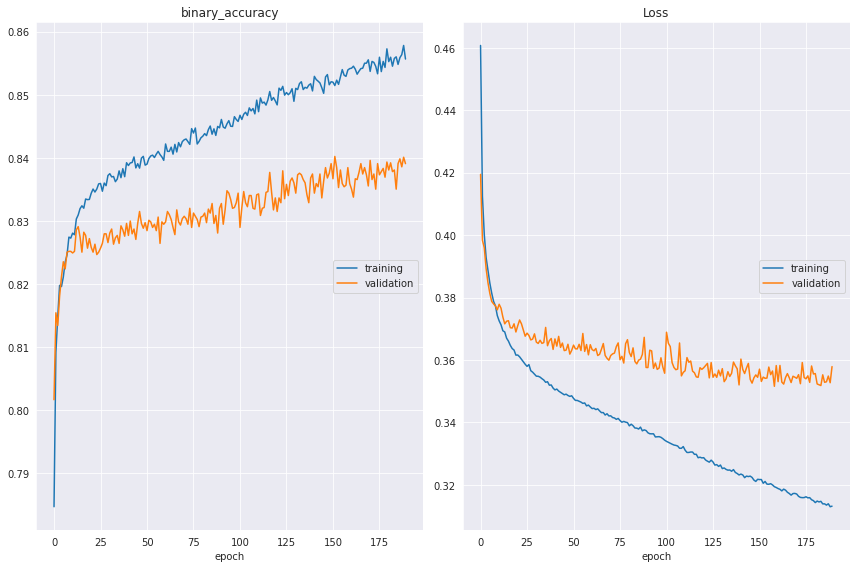

binary_accuracy
	training         	 (min:    0.785, max:    0.858, cur:    0.856)
	validation       	 (min:    0.802, max:    0.840, cur:    0.839)
Loss
	training         	 (min:    0.313, max:    0.461, cur:    0.313)
	validation       	 (min:    0.352, max:    0.419, cur:    0.358)


In [26]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)



model_history = test_network.fit(X_train_adult,
                                  y_train_adult, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_adult, y_valid_adult),
                                  verbose=0)



In [27]:
test_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
_________________________________________________________________


Epoch 000/150
8/8 [==============================] - 24s 2s/step - loss: 5.2046 - binary_crossentropy_inet_decision_function_fv_metric: 5.2046 - binary_accuracy_inet_decision_function_fv_metric: 0.5463 - val_loss: 8.2270 - val_binary_crossentropy_inet_decision_function_fv_metric: 8.2270 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4522
Epoch 001/150
8/8 [==============================] - 7s 859ms/step - loss: 5.5338 - binary_crossentropy_inet_decision_function_fv_metric: 5.5338 - binary_accuracy_inet_decision_function_fv_metric: 0.5827 - val_loss: 8.3471 - val_binary_crossentropy_inet_decision_function_fv_metric: 8.3471 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4543
Epoch 002/150
8/8 [==============================] - 7s 841ms/step - loss: 5.4167 - binary_crossentropy_inet_decision_function_fv_metric: 5.4167 - binary_accuracy_inet_decision_function_fv_metric: 0.5864 - val_loss: 8.3499 - val_binary_crossentropy_inet_decision_function_fv_metric: 8.3499 - val_

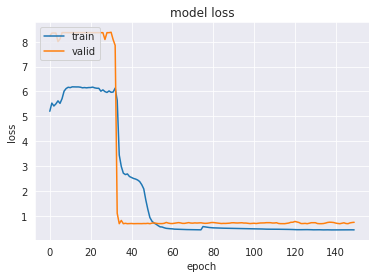

In [28]:
model = generate_inet(config, X_train_adult)

target_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)

callback_names = []
if config['i_net']['early_stopping']:
    callback_names.append('early_stopping')

callbacks = return_callbacks_from_string(callback_names)  

verbosity = 1

#%autoreload 2
############################## PREDICTION ###############################
X_valid_single = np.array([target_network_parameters])
X_train_single = None


y_valid_single = np.array([[0 for _ in range(basic_function_representation_length)]])
y_train_single_model = None#y_train[[index]].shape

mult_counter = 1
counter = 0
for i in range(epochs):
    print('Epoch ' + str(i).zfill(3) + '/' + str(epochs).zfill(3))
    if i < (epochs-50): #last 50 epochs without change in dataset

        if counter == 0:
            X_train_single = np.zeros((initial_parameters, number_of_lambda_weights))
            for j in range(initial_parameters):
                target_network_parameters_mutated = copy.deepcopy(target_network_parameters)

                target_network_parameters_range = (np.min(target_network_parameters), np.max(target_network_parameters))
                target_network_parameters_differential = target_network_parameters_range[1] - target_network_parameters_range[0]

                for _ in range(mutation_number):
                    mutation_index = random.randint(0, number_of_lambda_weights-1)
                    mutation_level = np.random.normal(loc=0.0, scale=target_network_parameters_differential)
                    target_network_parameters_mutated[mutation_index] = target_network_parameters_mutated[mutation_index] + mutation_level

                X_train_single[j] = target_network_parameters_mutated

        elif counter % (increase_interval_base*mult_counter) == 0:
            counter = 0
            mult_counter += 1
            X_train_single_new = np.zeros((X_train_single.shape[0]*extension_rate, number_of_lambda_weights))
            for j1, X_train_single_entry in enumerate(X_train_single):
                for j2 in range(extension_rate):
                    X_train_single_entry_mutated = copy.deepcopy(X_train_single_entry)

                    X_train_single_entry_range = (np.min(X_train_single_entry), np.max(X_train_single_entry))
                    X_train_single_entry_differential = X_train_single_entry_range[1] - X_train_single_entry_range[0]

                    for _ in range(mutation_number):
                        mutation_index = random.randint(0, number_of_lambda_weights-1)
                        mutation_level = np.random.normal(loc=0.0, scale=X_train_single_entry_differential)
                        X_train_single_entry_mutated[mutation_index] = X_train_single_entry_mutated[mutation_index] + mutation_level

                    X_train_single_new[(j2*X_train_single.shape[0])-1+j1] = X_train_single_entry_mutated                

            #X_train = X_train_new
            X_train_single_list = [X_train_single for _ in range(extension_rate)]
            X_train_single_list.append(X_train_single_new)
            X_train_single = np.vstack(X_train_single_list)    

        y_train_single = np.array([[0 for _ in range(basic_function_representation_length)] for _ in range(X_train_single.shape[0])])
        y_train_single_model = np.hstack((y_train_single, X_train_single))   
        valid_data_single = (X_valid_single, np.hstack((y_valid_single, X_valid_single)))                   
    
    #print(X_train_single.shape)
    #print(y_train_single_model.shape)
    #print(valid_data_single[0].shape, valid_data_single[1].shape)
    
    
    model_history = model.fit(X_train_single,
                      y_train_single_model,
                      epochs=1, 
                      batch_size=config['i_net']['batch_size'], 
                      validation_data=valid_data_single,
                      callbacks=callbacks,
                      verbose=verbosity)
    
    if i == 0:
        history = model_history.history
    else:
        history = mergeDict(history, model_history.history)

    counter += 1
    
    tf.keras.backend.clear_session()

if nas:
    for trial in history: 
        print(trial.summary())
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [29]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], 
                                                   config['data']['x_max'],
                                                   config['evaluation']['random_evaluation_dataset_size'], 
                                                   config['data']['number_of_variables'], 
                                                   config['data']['categorical_indices'])

y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_adult)

y_test_test_network_pred = test_network.predict(X_test_adult)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 18.366 (Sklearn DT) 	 0.745 (I-Net DT)
Accuracy:		 0.468 (Sklearn DT) 	 0.543 (I-Net DT)
F1 Score:		 0.04 (Sklearn DT) 	 0.704 (I-Net DT)


In [30]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)
print(splits, leaf_classes)

tf.Tensor(
[[0.5257299  0.         0.         ... 0.         0.         0.        ]
 [0.50740117 0.         0.         ... 0.         0.         0.        ]
 [0.557947   0.         0.         ... 0.         0.         0.        ]
 ...
 [0.54973245 0.         0.         ... 0.         0.         0.        ]
 [0.5314044  0.         0.         ... 0.         0.         0.        ]
 [0.48435974 0.         0.         ... 0.         0.         0.        ]], shape=(7, 43), dtype=float32) tf.Tensor(
[0.29632837 0.43323365 0.4276624  0.38677683 0.4440011  0.4487255
 0.45358837 0.38063377], shape=(8,), dtype=float32)


In [31]:
#%load_ext autoreload

In [32]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

In [ ]:
del model

## Titanic Dataset

In [ ]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

In [ ]:
titanic_data.describe()

In [ ]:
titanic_data.info()

In [ ]:
titanic_data = titanic_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis = 1)


In [ ]:
titanic_data.isnull().sum()

In [ ]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
#titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
features_select = [
                    'Pclass',
                    'Sex',    
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Embarked',
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = ['Embarked', 'Pclass']#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']
X_data_titanic.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
number_of_variables = X_data_titanic.shape[1]
config['data']['number_of_variables'] = number_of_variables


number_of_lambda_weights = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights


basic_function_representation_length = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = basic_function_representation_length


function_representation_length= ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * number_of_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
config['function_family']['function_representation_length'] = function_representation_length

In [ ]:
categorical_indices = []

for i, (column_name, column) in enumerate(X_data_titanic.iteritems()):
    if len(column.value_counts()) == 2:
        categorical_indices.append(i)
print(categorical_indices)

config['data']['categorical_indices'] = categorical_indices

In [ ]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

In [ ]:
y_data_titanic

In [ ]:
true_labels = len(y_data_titanic[y_data_titanic >= 0.5 ]) 
false_labels = len(y_data_titanic[y_data_titanic < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_data_titanic, y_data_titanic = oversample.fit_resample(X_data_titanic, y_data_titanic)

    true_labels = len(y_data_titanic[y_data_titanic >= 0.5 ]) 
    false_labels = len(y_data_titanic[y_data_titanic < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

In [ ]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_titanic,
                                  y_train_titanic, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_titanic, y_valid_titanic),
                                  verbose=0)



In [ ]:
test_network.summary()

In [ ]:
model = generate_inet(config, X_train_titanic)

target_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)

callback_names = []
if config['i_net']['early_stopping']:
    callback_names.append('early_stopping')

callbacks = return_callbacks_from_string(callback_names)  

verbosity = 1

#%autoreload 2
############################## PREDICTION ###############################
X_valid_single = np.array([target_network_parameters])
X_train_single = None


y_valid_single = np.array([[0 for _ in range(basic_function_representation_length)]])
y_train_model_single = None#y_train[[index]].shape

mult_counter = 1
counter = 0
for i in range(epochs):
    print('Epoch ' + str(i).zfill(3) + '/' + str(epochs).zfill(3))
    if i < (epochs-50): #last 50 epochs without change in dataset

        if counter == 0:
            X_train_single = np.zeros((initial_parameters, number_of_lambda_weights))
            for j in range(initial_parameters):
                target_network_parameters_mutated = copy.deepcopy(target_network_parameters)

                target_network_parameters_range = (np.min(target_network_parameters), np.max(target_network_parameters))
                target_network_parameters_differential = target_network_parameters_range[1] - target_network_parameters_range[0]

                for _ in range(mutation_number):
                    mutation_index = random.randint(0, number_of_lambda_weights-1)
                    mutation_level = np.random.normal(loc=0.0, scale=target_network_parameters_differential)
                    target_network_parameters_mutated[mutation_index] = target_network_parameters_mutated[mutation_index] + mutation_level

                X_train_single[j] = target_network_parameters_mutated

        elif counter % (increase_interval_base*mult_counter) == 0:
            counter = 0
            mult_counter += 1
            X_train_single_new = np.zeros((X_train_single.shape[0]*extension_rate, number_of_lambda_weights))
            for j1, X_train_single_entry in enumerate(X_train_single):
                for j2 in range(extension_rate):
                    X_train_single_entry_mutated = copy.deepcopy(X_train_single_entry)

                    X_train_single_entry_range = (np.min(X_train_single_entry), np.max(X_train_single_entry))
                    X_train_single_entry_differential = X_train_single_entry_range[1] - X_train_single_entry_range[0]

                    for _ in range(mutation_number):
                        mutation_index = random.randint(0, number_of_lambda_weights-1)
                        mutation_level = np.random.normal(loc=0.0, scale=X_train_single_entry_differential)
                        X_train_single_entry_mutated[mutation_index] = X_train_single_entry_mutated[mutation_index] + mutation_level

                    X_train_single_new[(j2*X_train_single.shape[0])-1+j1] = X_train_single_entry_mutated                

            #X_train = X_train_new
            X_train_single_list = [X_train_single for _ in range(extension_rate)]
            X_train_single_list.append(X_train_single_new)
            X_train_single = np.vstack(X_train_single_list)    

        y_train_single = np.array([[0 for _ in range(basic_function_representation_length)] for _ in range(X_train_single.shape[0])])
        y_train_single_model = np.hstack((y_train_single, X_train_single))   
        valid_data_single = (X_valid_single, np.hstack((y_valid_single, X_valid_single)))                   
    
    #print(X_train_single.shape)
    #print(y_train_single_model.shape)
    #print(valid_data_single[0].shape, valid_data_single[1].shape)
    
    
    model_history = model.fit(X_train_single,
                      y_train_single_model,
                      epochs=1, 
                      batch_size=config['i_net']['batch_size'], 
                      validation_data=valid_data_single,
                      callbacks=callbacks,
                      verbose=verbosity)
    
    if i == 0:
        history = model_history.history
    else:
        history = mergeDict(history, model_history.history)

    counter += 1
    
    tf.keras.backend.clear_session()

if nas:
    for trial in history: 
        print(trial.summary())
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [ ]:
config['data']['number_of_variables']

In [ ]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], 
                                                   config['data']['x_max'],
                                                   config['evaluation']['random_evaluation_dataset_size'], 
                                                   config['data']['number_of_variables'], 
                                                   config['data']['categorical_indices'])
#X_data_random = X_train_titanic.values#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], 30, config['data']['number_of_variables'])

y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_titanic)

y_test_test_network_pred = test_network.predict(X_test_titanic)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


In [ ]:
X_data_titanic.head(5)

In [ ]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

In [ ]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

In [ ]:
y_test_test_network_pred[:50].ravel()

In [ ]:
y_test_distilled_sklearn_dt[:50].ravel()

In [ ]:
np.round(y_test_inet_dt[:50]).ravel()

In [ ]:
del model

## Absenteeism at Work Dataset

In [ ]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

absenteeism_data.head()

In [ ]:
absenteeism_data.describe()

In [ ]:
absenteeism_data.info()

In [ ]:
absenteeism_data.isnull().sum()

In [ ]:
features_select = [
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Disciplinary failure', 
                           'Education', 
                           'Son', 
                           'Social drinker',
                           'Social smoker', 
                           #'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

categorical_features = ['Education']#[1, 2, 7]
ordinal_features = []

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(absenteeism_data)

absenteeism_data = transformer.transform(absenteeism_data)
absenteeism_data = pd.DataFrame(absenteeism_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    absenteeism_data[ordinal_feature] = OrdinalEncoder().fit_transform(absenteeism_data[ordinal_feature].values.reshape(-1, 1)).flatten()

absenteeism_data = absenteeism_data.astype(np.float64)

    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 3) * 1) #absenteeism_data['Absenteeism time in hours']

print(X_data_absenteeism.shape)

X_data_absenteeism.head()

In [ ]:
number_of_variables = X_data_absenteeism.shape[1]
config['data']['number_of_variables'] = number_of_variables


number_of_lambda_weights = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights


basic_function_representation_length = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = basic_function_representation_length


function_representation_length= ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * number_of_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
config['function_family']['function_representation_length'] = function_representation_length

In [ ]:
categorical_indices = []

for i, (column_name, column) in enumerate(X_data_absenteeism.iteritems()):
    if len(column.value_counts()) == 2:
        categorical_indices.append(i)
print(categorical_indices)

config['data']['categorical_indices'] = categorical_indices

In [ ]:
normalizer_list = []
for column_name in X_data_absenteeism:
    scaler = MinMaxScaler()
    scaler.fit(X_data_absenteeism[column_name].values.reshape(-1, 1))
    X_data_absenteeism[column_name] = scaler.transform(X_data_absenteeism[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_absenteeism.head()

In [ ]:
y_data_absenteeism

In [ ]:
true_labels = len(y_data_absenteeism[y_data_absenteeism >= 0.5 ]) 
false_labels = len(y_data_absenteeism[y_data_absenteeism < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.4 or true_ratio >= 0.6:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_data_absenteeism, y_data_absenteeism = oversample.fit_resample(X_data_absenteeism, y_data_absenteeism)

    true_labels = len(y_data_absenteeism[y_data_absenteeism >= 0.5 ]) 
    false_labels = len(y_data_absenteeism[y_data_absenteeism < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
X_train_absenteeism_with_valid, X_test_absenteeism, y_train_absenteeism_with_valid, y_test_absenteeism = train_test_split(X_data_absenteeism, y_data_absenteeism, train_size=0.8)
X_train_absenteeism, X_valid_absenteeism, y_train_absenteeism, y_valid_absenteeism = train_test_split(X_train_absenteeism_with_valid, y_train_absenteeism_with_valid, train_size=0.8)

print(X_train_absenteeism.shape, y_train_absenteeism.shape)
print(X_valid_absenteeism.shape, y_valid_absenteeism.shape)
print(X_test_absenteeism.shape, y_test_absenteeism.shape)

In [ ]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_absenteeism,
                                  y_train_absenteeism, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_absenteeism, y_valid_absenteeism),
                                  verbose=0)



In [ ]:
test_network.summary()

In [ ]:
model = generate_inet(config, X_train_absenteeism)

target_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)

callback_names = []
if config['i_net']['early_stopping']:
    callback_names.append('early_stopping')

callbacks = return_callbacks_from_string(callback_names)  

verbosity = 1

#%autoreload 2
############################## PREDICTION ###############################
X_valid_single = np.array([target_network_parameters])
X_train_single = None


y_valid_single = np.array([[0 for _ in range(basic_function_representation_length)]])
y_train_model_single = None#y_train[[index]].shape

mult_counter = 1
counter = 0
for i in range(epochs):
    print('Epoch ' + str(i).zfill(3) + '/' + str(epochs).zfill(3))
    if i < (epochs-50): #last 50 epochs without change in dataset

        if counter == 0:
            X_train_single = np.zeros((initial_parameters, number_of_lambda_weights))
            for j in range(initial_parameters):
                target_network_parameters_mutated = copy.deepcopy(target_network_parameters)

                target_network_parameters_range = (np.min(target_network_parameters), np.max(target_network_parameters))
                target_network_parameters_differential = target_network_parameters_range[1] - target_network_parameters_range[0]

                for _ in range(mutation_number):
                    mutation_index = random.randint(0, number_of_lambda_weights-1)
                    mutation_level = np.random.normal(loc=0.0, scale=target_network_parameters_differential)
                    target_network_parameters_mutated[mutation_index] = target_network_parameters_mutated[mutation_index] + mutation_level

                X_train_single[j] = target_network_parameters_mutated

        elif counter % (increase_interval_base*mult_counter) == 0:
            counter = 0
            mult_counter += 1
            X_train_single_new = np.zeros((X_train_single.shape[0]*extension_rate, number_of_lambda_weights))
            for j1, X_train_single_entry in enumerate(X_train_single):
                for j2 in range(extension_rate):
                    X_train_single_entry_mutated = copy.deepcopy(X_train_single_entry)

                    X_train_single_entry_range = (np.min(X_train_single_entry), np.max(X_train_single_entry))
                    X_train_single_entry_differential = X_train_single_entry_range[1] - X_train_single_entry_range[0]

                    for _ in range(mutation_number):
                        mutation_index = random.randint(0, number_of_lambda_weights-1)
                        mutation_level = np.random.normal(loc=0.0, scale=X_train_single_entry_differential)
                        X_train_single_entry_mutated[mutation_index] = X_train_single_entry_mutated[mutation_index] + mutation_level

                    X_train_single_new[(j2*X_train_single.shape[0])-1+j1] = X_train_single_entry_mutated                

            #X_train = X_train_new
            X_train_single_list = [X_train_single for _ in range(extension_rate)]
            X_train_single_list.append(X_train_single_new)
            X_train_single = np.vstack(X_train_single_list)    

        y_train_single = np.array([[0 for _ in range(basic_function_representation_length)] for _ in range(X_train_single.shape[0])])
        y_train_single_model = np.hstack((y_train_single, X_train_single))   
        valid_data_single = (X_valid_single, np.hstack((y_valid_single, X_valid_single)))                   
    
    #print(X_train_single.shape)
    #print(y_train_single_model.shape)
    #print(valid_data_single[0].shape, valid_data_single[1].shape)
    
    
    model_history = model.fit(X_train_single,
                      y_train_single_model,
                      epochs=1, 
                      batch_size=config['i_net']['batch_size'], 
                      validation_data=valid_data_single,
                      callbacks=callbacks,
                      verbose=verbosity)
    
    if i == 0:
        history = model_history.history
    else:
        history = mergeDict(history, model_history.history)

    counter += 1
    
    tf.keras.backend.clear_session()

if nas:
    for trial in history: 
        print(trial.summary())
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [ ]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], 
                                                   config['data']['x_max'],
                                                   config['evaluation']['random_evaluation_dataset_size'], 
                                                   config['data']['number_of_variables'], 
                                                   config['data']['categorical_indices'])

#X_data_random = X_train_absenteeism.values

y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_absenteeism, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_absenteeism, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_absenteeism)

y_test_test_network_pred = test_network.predict(X_test_absenteeism)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


In [ ]:
X_data_absenteeism.head(5)

In [ ]:
test_network_dt_inet

In [ ]:
get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)

In [ ]:
get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)

In [ ]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

In [ ]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config)
image
#tree.show()

In [ ]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

In [ ]:
y_test_test_network_pred[:50].ravel()

In [ ]:
y_test_distilled_sklearn_dt[:50].ravel()

In [ ]:
np.round(y_test_inet_dt[:50]).ravel()

In [ ]:
del model

In [ ]:
print('DONE')

## NEXT DATASET

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()